In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
    return image

def add_noise(image):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1)  # Reduced noise
    noisy_image = tf.clip_by_value(image + noise, -1.0, 1.0)
    return noisy_image, image

# Use only 10% of the training data for faster testing
(train_data, _), ds_info = tfds.load('cifar10', split=['train[:10%]', 'train[90%:]'],
                                     as_supervised=True, with_info=True)

train_dataset = train_data.map(lambda x, y: normalize(x))
train_dataset = train_dataset.map(add_noise)
train_dataset = train_dataset.shuffle(1000).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.EBJ27W_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.EBJ27W_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same', kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[32, 32, 3])
    down1 = downsample(64, 4, apply_batchnorm=False)(inputs)
    down2 = downsample(128, 4)(down1)

    up1 = upsample(64, 4)(down2)
    concat1 = tf.keras.layers.Concatenate()([up1, down1])

    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(concat1)
    return tf.keras.Model(inputs=inputs, outputs=last)


In [4]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[32, 32, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[32, 32, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [5]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Warm-up models
dummy_input = tf.random.normal([1, 32, 32, 3])
_ = generator(dummy_input)
_ = discriminator([dummy_input, dummy_input])

In [6]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [8]:

def generate_images(model, test_input, target):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(10, 3))
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Noisy Input', 'Target (Clean)', 'Predicted (Denoised)']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()


Epoch 1/100
Generator Loss: 7.3782, Discriminator Loss: 0.8409
Epoch 2/100
Generator Loss: 7.4581, Discriminator Loss: 0.8364
Epoch 3/100
Generator Loss: 7.4809, Discriminator Loss: 0.8394
Epoch 4/100
Generator Loss: 7.7338, Discriminator Loss: 0.7309
Epoch 5/100
Generator Loss: 7.6825, Discriminator Loss: 0.7005
Epoch 6/100
Generator Loss: 7.8537, Discriminator Loss: 0.6992
Epoch 7/100
Generator Loss: 7.9279, Discriminator Loss: 0.6344
Epoch 8/100
Generator Loss: 7.9175, Discriminator Loss: 0.7187
Epoch 9/100
Generator Loss: 7.8269, Discriminator Loss: 0.7213
Epoch 10/100
Generator Loss: 8.0493, Discriminator Loss: 0.5988


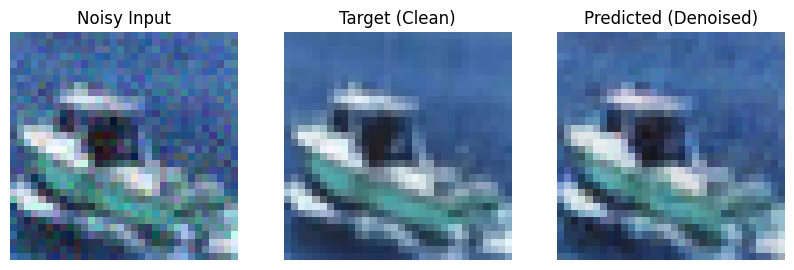

Epoch 11/100
Generator Loss: 8.0426, Discriminator Loss: 0.7408
Epoch 12/100
Generator Loss: 8.1494, Discriminator Loss: 0.5825
Epoch 13/100
Generator Loss: 7.9470, Discriminator Loss: 0.6942
Epoch 14/100
Generator Loss: 8.0573, Discriminator Loss: 0.6843
Epoch 15/100
Generator Loss: 7.6983, Discriminator Loss: 0.8744
Epoch 16/100
Generator Loss: 8.1000, Discriminator Loss: 0.6025
Epoch 17/100
Generator Loss: 8.2551, Discriminator Loss: 0.6143
Epoch 18/100
Generator Loss: 8.1618, Discriminator Loss: 0.6134
Epoch 19/100
Generator Loss: 8.0528, Discriminator Loss: 0.6964
Epoch 20/100
Generator Loss: 8.0326, Discriminator Loss: 0.7649


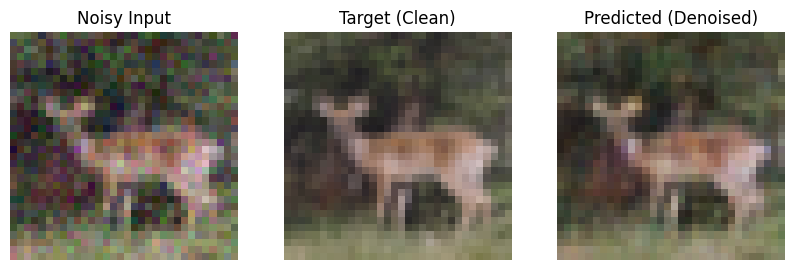

Epoch 21/100
Generator Loss: 7.8724, Discriminator Loss: 0.6974
Epoch 22/100
Generator Loss: 7.9550, Discriminator Loss: 0.7188
Epoch 23/100
Generator Loss: 8.0205, Discriminator Loss: 0.6955
Epoch 24/100
Generator Loss: 8.0435, Discriminator Loss: 0.7027
Epoch 25/100
Generator Loss: 8.0030, Discriminator Loss: 0.6822
Epoch 26/100
Generator Loss: 7.8500, Discriminator Loss: 0.9374
Epoch 27/100
Generator Loss: 7.9563, Discriminator Loss: 0.6973
Epoch 28/100
Generator Loss: 8.0737, Discriminator Loss: 0.6865
Epoch 29/100
Generator Loss: 7.7182, Discriminator Loss: 0.8797
Epoch 30/100
Generator Loss: 7.9088, Discriminator Loss: 0.6845


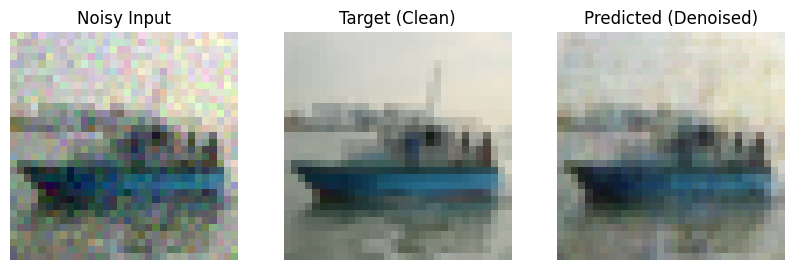

Epoch 31/100
Generator Loss: 7.7078, Discriminator Loss: 0.7850
Epoch 32/100
Generator Loss: 7.9284, Discriminator Loss: 0.6894
Epoch 33/100
Generator Loss: 7.6453, Discriminator Loss: 0.9212
Epoch 34/100
Generator Loss: 7.6224, Discriminator Loss: 0.8051
Epoch 35/100
Generator Loss: 7.7518, Discriminator Loss: 0.8405
Epoch 36/100
Generator Loss: 7.7140, Discriminator Loss: 0.7281
Epoch 37/100
Generator Loss: 7.7430, Discriminator Loss: 0.7302
Epoch 38/100
Generator Loss: 7.7815, Discriminator Loss: 0.7396
Epoch 39/100
Generator Loss: 7.7720, Discriminator Loss: 0.7796
Epoch 40/100
Generator Loss: 7.7556, Discriminator Loss: 0.7600


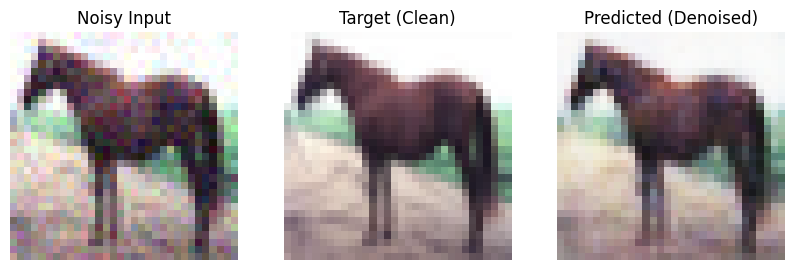

Epoch 41/100
Generator Loss: 8.0562, Discriminator Loss: 0.7430
Epoch 42/100
Generator Loss: 7.7678, Discriminator Loss: 0.7744
Epoch 43/100
Generator Loss: 7.8811, Discriminator Loss: 0.7095
Epoch 44/100
Generator Loss: 7.7057, Discriminator Loss: 0.8819
Epoch 45/100
Generator Loss: 7.5755, Discriminator Loss: 0.7800
Epoch 46/100
Generator Loss: 7.6112, Discriminator Loss: 0.8459
Epoch 47/100
Generator Loss: 7.7458, Discriminator Loss: 0.7468
Epoch 48/100
Generator Loss: 7.8042, Discriminator Loss: 0.7499
Epoch 49/100
Generator Loss: 7.6733, Discriminator Loss: 0.8072
Epoch 50/100
Generator Loss: 7.7677, Discriminator Loss: 0.7377


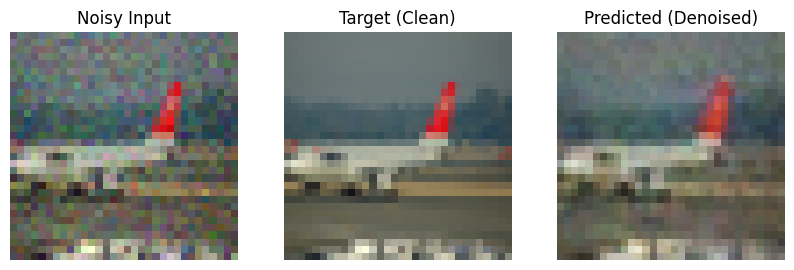

Epoch 51/100
Generator Loss: 7.9445, Discriminator Loss: 0.6660
Epoch 52/100
Generator Loss: 7.7867, Discriminator Loss: 0.8046
Epoch 53/100
Generator Loss: 7.8404, Discriminator Loss: 0.7270
Epoch 54/100
Generator Loss: 7.7886, Discriminator Loss: 0.7048
Epoch 55/100
Generator Loss: 7.8122, Discriminator Loss: 0.9016
Epoch 56/100
Generator Loss: 7.5799, Discriminator Loss: 0.7061
Epoch 57/100
Generator Loss: 7.8317, Discriminator Loss: 0.6188
Epoch 58/100
Generator Loss: 7.7631, Discriminator Loss: 0.8535
Epoch 59/100
Generator Loss: 7.8897, Discriminator Loss: 0.6777
Epoch 60/100
Generator Loss: 7.9775, Discriminator Loss: 0.7275


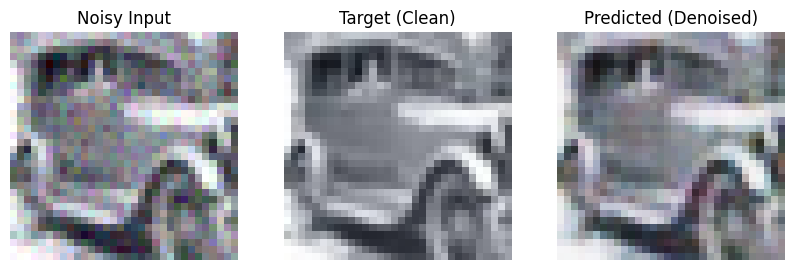

Epoch 61/100
Generator Loss: 7.7978, Discriminator Loss: 0.7184
Epoch 62/100
Generator Loss: 7.6701, Discriminator Loss: 0.7577
Epoch 63/100
Generator Loss: 7.6746, Discriminator Loss: 0.7656
Epoch 64/100
Generator Loss: 7.6369, Discriminator Loss: 0.7380
Epoch 65/100
Generator Loss: 8.0015, Discriminator Loss: 0.5808
Epoch 66/100
Generator Loss: 7.9313, Discriminator Loss: 0.6558
Epoch 67/100
Generator Loss: 7.6168, Discriminator Loss: 1.1134
Epoch 68/100
Generator Loss: 6.8615, Discriminator Loss: 1.0200
Epoch 69/100
Generator Loss: 7.7014, Discriminator Loss: 0.7845
Epoch 70/100
Generator Loss: 7.7723, Discriminator Loss: 0.7111


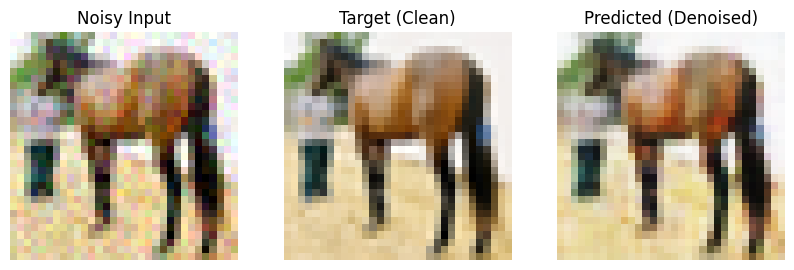

Epoch 71/100
Generator Loss: 7.7944, Discriminator Loss: 0.6538
Epoch 72/100
Generator Loss: 7.8800, Discriminator Loss: 0.6186
Epoch 73/100
Generator Loss: 7.9107, Discriminator Loss: 0.6937
Epoch 74/100
Generator Loss: 7.9515, Discriminator Loss: 0.7082
Epoch 75/100
Generator Loss: 7.5048, Discriminator Loss: 0.7978
Epoch 76/100
Generator Loss: 7.8420, Discriminator Loss: 0.7484
Epoch 77/100
Generator Loss: 7.7494, Discriminator Loss: 0.7222
Epoch 78/100
Generator Loss: 7.7769, Discriminator Loss: 0.7242
Epoch 79/100
Generator Loss: 7.9229, Discriminator Loss: 0.5836
Epoch 80/100
Generator Loss: 7.9094, Discriminator Loss: 0.5759


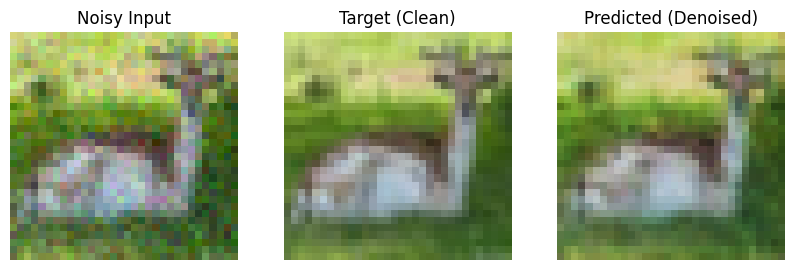

Epoch 81/100
Generator Loss: 8.0046, Discriminator Loss: 0.6814
Epoch 82/100
Generator Loss: 7.7129, Discriminator Loss: 0.7652
Epoch 83/100
Generator Loss: 7.8189, Discriminator Loss: 0.6737
Epoch 84/100
Generator Loss: 7.7454, Discriminator Loss: 0.6915
Epoch 85/100
Generator Loss: 7.9446, Discriminator Loss: 0.5838
Epoch 86/100
Generator Loss: 7.9204, Discriminator Loss: 0.8538
Epoch 87/100
Generator Loss: 7.8988, Discriminator Loss: 0.5911
Epoch 88/100
Generator Loss: 7.9990, Discriminator Loss: 0.6764
Epoch 89/100
Generator Loss: 7.8569, Discriminator Loss: 0.6285
Epoch 90/100
Generator Loss: 8.0846, Discriminator Loss: 0.6092


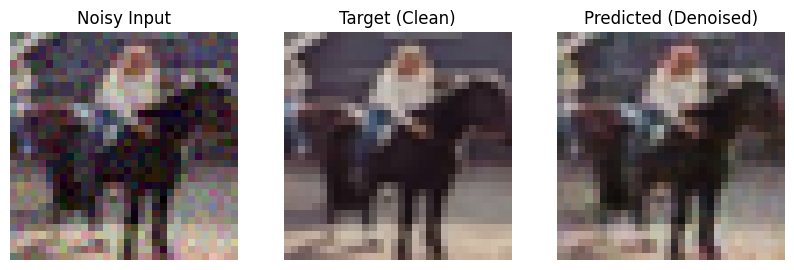

Epoch 91/100
Generator Loss: 7.9628, Discriminator Loss: 0.7833
Epoch 92/100
Generator Loss: 8.1628, Discriminator Loss: 0.5531
Epoch 93/100
Generator Loss: 8.2195, Discriminator Loss: 0.6108
Epoch 94/100
Generator Loss: 8.1661, Discriminator Loss: 0.6552
Epoch 95/100
Generator Loss: 8.0139, Discriminator Loss: 0.7615
Epoch 96/100
Generator Loss: 8.0358, Discriminator Loss: 0.6219
Epoch 97/100
Generator Loss: 8.2560, Discriminator Loss: 0.5399
Epoch 98/100
Generator Loss: 8.1390, Discriminator Loss: 0.6560
Epoch 99/100
Generator Loss: 8.1815, Discriminator Loss: 0.6911
Epoch 100/100
Generator Loss: 8.3348, Discriminator Loss: 0.5407


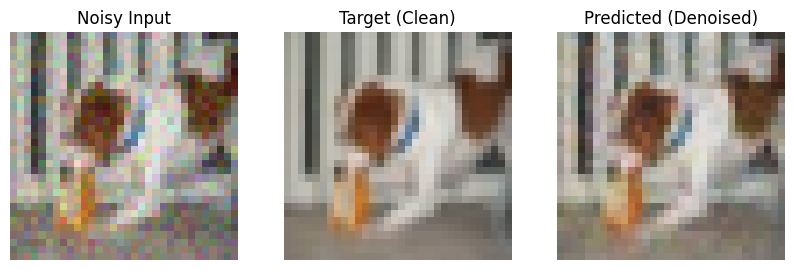

In [9]:
EPOCHS = 100
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    gen_loss_epoch = 0
    disc_loss_epoch = 0
    steps = 0
    for input_image, target in train_dataset:
        gen_loss, disc_loss = train_step(input_image, target)
        gen_loss_epoch += gen_loss
        disc_loss_epoch += disc_loss
        steps += 1

    print(f"Generator Loss: {gen_loss_epoch / steps:.4f}, Discriminator Loss: {disc_loss_epoch / steps:.4f}")

    # Only visualize every 10 epochs to reduce lag
    if (epoch + 1) % 10 == 0:
        sample_batch = next(iter(train_dataset))
        noisy_sample, clean_sample = sample_batch
        generate_images(generator, noisy_sample, clean_sample)